<a href="https://colab.research.google.com/github/iamshnoo/face_recognition/blob/master/mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*IMPORT LIBRARIES*

In [0]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np


**AlexNet architecture**

---

*Facial Keypoints Detector*

In [0]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
# can use the below import should you choose to initialize the weights of your Net
import torch.nn.init as I

class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        ## Conv layers
        # input of size (1 x 227 x 227)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=96, kernel_size=(4, 4), stride=4, padding=0) # VALID
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=(5, 5), stride=1, padding=2) # SAME
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=(3, 3), stride=1, padding=1) # SAME
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=(3, 3), stride=1, padding=1) # SAME
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=(3, 3), stride=1, padding=1) # SAME
        
        ## Max-Pool layer 
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        
        ## Linear layers
        self.fc1 = nn.Linear(in_features=9216, out_features=4096)
        self.fc2 = nn.Linear(in_features=4096, out_features=4096)
        self.fc3 = nn.Linear(in_features=4096, out_features=136)
        
        ## Dropout 
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout4 = nn.Dropout(p=0.4)
        self.dropout6 = nn.Dropout(p=0.6)
        
        # Batch Normalization
        self.bn1 = nn.BatchNorm2d(num_features=96, eps=1e-05)
        self.bn2 = nn.BatchNorm2d(num_features=256, eps=1e-05)
        self.bn3 = nn.BatchNorm2d(num_features=384, eps=1e-05)
        self.bn4 = nn.BatchNorm2d(num_features=384, eps=1e-05)
        self.bn5 = nn.BatchNorm2d(num_features=256, eps=1e-05)
        self.bn6 = nn.BatchNorm1d(num_features=4096, eps=1e-05)
        self.bn7 = nn.BatchNorm1d(num_features=4096, eps=1e-05)
        
        # Custom weights initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight = nn.init.xavier_uniform_(m.weight, gain=1)
            elif isinstance(m, nn.Linear):
                # FC layers have weights initialized with Glorot uniform initialization
                m.weight = nn.init.xavier_uniform_(m.weight, gain=1)

    def forward(self, x):
        
        ## Conv layers
        x = F.elu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.elu(self.conv2(x))
        x = self.bn2(x)
        x = self.pool(x)
        
        x = F.elu(self.conv3(x))
        x = self.bn3(x)
        x = self.dropout4(x)
        
        x = F.elu(self.conv4(x))
        x = self.bn4(x)
        x = self.dropout4(x)
        
        x = F.elu(self.conv5(x))
        x = self.bn5(x)
        x = self.pool(x)

        ## Flatten
        x = x.view(x.size(0), -1) 
        
        ## Fully connected layers
        x = F.elu(self.fc1(x))
        x = self.bn6(x)
        x = self.dropout6(x)
        
        x = F.elu(self.fc2(x))
        x = self.bn6(x)
        x = self.dropout6(x)
        

        x = self.fc3(x)
    
        return x


# I tried to use my laptop's gpu. It wasn't working properly.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

net = Net()
net.to(device)
print(net)

Net(
  (conv1): Conv2d(1, 96, kernel_size=(4, 4), stride=(4, 4))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=136, bias=True)
  (dropout2): Dropout(p=0.2)
  (dropout4): Dropout(p=0.4)
  (dropout6): Dropout(p=0.6)
  (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_

**Get dataset for keypoints**

In [0]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

**Dataloader and Transforms**


---

*Required Pre-proccessing for the Keypoints dataset*

In [0]:
import glob
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.image as mpimg
import pandas as pd
import cv2


class FacialKeypointsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.key_pts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_pts_frame)

    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir,
                                self.key_pts_frame.iloc[idx, 0])
        
        image = mpimg.imread(image_name)
        
        # if image has an alpha color channel, get rid of it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
        
        key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
        key_pts = key_pts.astype('float').reshape(-1, 2)
        sample = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)

        return sample
    

    
# tranforms

class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""        

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
            
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts_copy = (key_pts_copy - 100)/50.0


        return {'image': image_copy, 'keypoints': key_pts_copy}


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': key_pts}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}



---


*Creating Dataloader and testing it out*

---



In [0]:
from torchvision import transforms, utils

## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose( [Rescale(250) , RandomCrop(227) , Normalize() , ToTensor()] )
                                     
# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [0]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 227, 227]) torch.Size([68, 2])
1 torch.Size([1, 227, 227]) torch.Size([68, 2])
2 torch.Size([1, 227, 227]) torch.Size([68, 2])
3 torch.Size([1, 227, 227]) torch.Size([68, 2])


In [0]:
# load training data in batches
batch_size = 40

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


In [0]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)


In [0]:
# load test data in batches
batch_size = 40

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

In [0]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        
        # I tried to use my laptop's gpu. It wasn't working properly.
        images = images.to(device)
        key_pts = key_pts.to(device)
        
        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

In [0]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([40, 1, 227, 227])
torch.Size([40, 68, 2])
torch.Size([40, 68, 2])




---

*Auxiliary functions to plot keypoints*


---



In [0]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    #if gt_pts is not None:
    #    plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


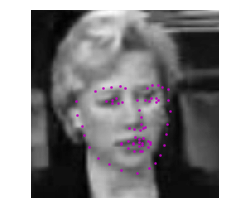

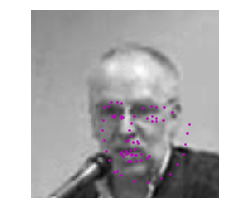

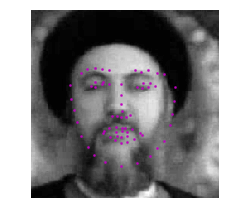

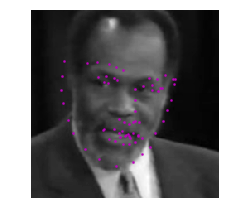

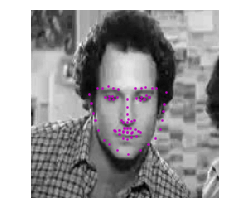

In [0]:
# visualize the output
# by default this shows a batch of 5 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=5):

    for i in range(batch_size):
        plt.figure(figsize=(30,20))
        ax = plt.subplot( batch_size, 1, i+1)
        
        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        
        # I tried to use my laptop's gpu. It wasn't working properly.
        if torch.cuda.is_available():
            image = image.cpu()
            
        image = image.data
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        
        # I tried to use my laptop's gpu. It wasn't working properly.
        if torch.cuda.is_available():
            predicted_key_pts = predicted_key_pts.cpu()
            
        predicted_key_pts = predicted_key_pts.data
        predicted_key_pts = predicted_key_pts.numpy()
        
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        
        if gt_pts is not None:
            
            ground_truth_pts = gt_pts[i] 
            
            # I tried to use my laptop's gpu. It wasn't working properly.
            if torch.cuda.is_available():
                ground_truth_pts = ground_truth_pts.cpu()  
                
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

**Training AlexNet (keypoints)**

In [0]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss()
# criterion = nn.MSELoss() # not giving much better accuracy as of the all attempts I made.

optimizer = optim.Adam(net.parameters(), lr = 0.001)

In [0]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            key_pts, images = key_pts.to(device), images.to(device)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [0]:
# train the network
n_epochs = 70 

train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.7400993704795837
Epoch: 1, Batch: 20, Avg. Loss: 0.5961719155311584
Epoch: 1, Batch: 30, Avg. Loss: 0.49096316695213316
Epoch: 1, Batch: 40, Avg. Loss: 0.3842829555273056
Epoch: 1, Batch: 50, Avg. Loss: 0.31887239813804624
Epoch: 1, Batch: 60, Avg. Loss: 0.30531065464019774
Epoch: 1, Batch: 70, Avg. Loss: 0.29041857421398165
Epoch: 1, Batch: 80, Avg. Loss: 0.296794119477272
Epoch: 2, Batch: 10, Avg. Loss: 0.25581789314746856
Epoch: 2, Batch: 20, Avg. Loss: 0.24602040499448777
Epoch: 2, Batch: 30, Avg. Loss: 0.23979466557502746
Epoch: 2, Batch: 40, Avg. Loss: 0.2574600428342819
Epoch: 2, Batch: 50, Avg. Loss: 0.27124146968126295
Epoch: 2, Batch: 60, Avg. Loss: 0.29288352727890016
Epoch: 2, Batch: 70, Avg. Loss: 0.2668382704257965
Epoch: 2, Batch: 80, Avg. Loss: 0.2417069971561432
Epoch: 3, Batch: 10, Avg. Loss: 0.2375551536679268
Epoch: 3, Batch: 20, Avg. Loss: 0.23204175680875777
Epoch: 3, Batch: 30, Avg. Loss: 0.232035094499588
Epoch: 3, Batch: 40, Av

**Accuracy and loss calculations**

In [0]:
# test the model on a batch of test images
import torch.optim as optim
criterion = nn.SmoothL1Loss().cuda()

def sample_output():
    total = 0
    correct = 0
    running_loss = 0.0
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        total += 68
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']
        t_pts = key_pts.view(key_pts.size(0), -1)
        t_pts = t_pts.type(torch.FloatTensor)
        t_pts = t_pts.to(device)

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        
        # I tried to use my laptop's gpu. It wasn't working properly.
        images = images.to(device)
        key_pts = key_pts.to(device)
        
        # forward pass to get net output
        output_pts = net(images)
        
        loss = criterion(output_pts, t_pts)
        running_loss += loss.item()
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)

        #true_pts = key_pts.float()
        list_1 = key_pts[1].cpu().numpy()
        list_2 = output_pts[1].detach().cpu().numpy()
        
        for i in range(len(list_1)):
          pred = ( (list_1[i] - list_2[i]) <= 0.21 )
          if(pred.all()==True):
            correct += 1

    accuracy = (correct/total)*100
    return accuracy,running_loss

In [0]:
b = 0
c = 0
for i in range(19):
  a,l = sample_output()
  b += a
  c += l
  print('Batch ' + str(i+1) + '  - ' + ' Accuracy : ' + str(round(a,2)) + '    Loss : ' + str(round(l,2)))
  
b = b/19
c = c/19

print('Average accuracy in 760 test images : ' + str(round(b,2)) )
print('Average loss in 760 test images : ' + str(round(c,2)) )

Batch 1  -  Accuracy : 84.85    Loss : 0.23
Batch 2  -  Accuracy : 97.57    Loss : 0.22
Batch 3  -  Accuracy : 93.24    Loss : 0.17
Batch 4  -  Accuracy : 82.79    Loss : 0.24
Batch 5  -  Accuracy : 92.79    Loss : 0.2
Batch 6  -  Accuracy : 88.46    Loss : 0.19
Batch 7  -  Accuracy : 85.51    Loss : 0.22
Batch 8  -  Accuracy : 90.88    Loss : 0.23
Batch 9  -  Accuracy : 94.41    Loss : 0.18
Batch 10  -  Accuracy : 91.4    Loss : 0.18
Batch 11  -  Accuracy : 88.38    Loss : 0.18
Batch 12  -  Accuracy : 90.44    Loss : 0.19
Batch 13  -  Accuracy : 88.68    Loss : 0.18
Batch 14  -  Accuracy : 91.99    Loss : 0.21
Batch 15  -  Accuracy : 84.49    Loss : 0.19
Batch 16  -  Accuracy : 88.24    Loss : 0.18
Batch 17  -  Accuracy : 79.71    Loss : 0.2
Batch 18  -  Accuracy : 94.04    Loss : 0.22
Batch 19  -  Accuracy : 94.26    Loss : 0.18
Average accuracy in 760 test images : 89.59
Average loss in 760 test images : 0.2


*Values of Accuracy and Loss for AlexNet training*



---

**Test Results :**</br>
**Trained AlexNet on 3462 faces from Youtube Faces Dataset**</br>
**Train : Test split is approximately 5:1**

**Average accuracy in 760 test images : 89.59 </br>
    Average loss in 760 test images : 0.2**

---



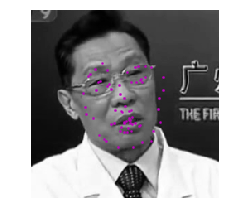

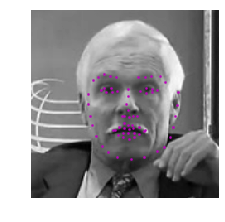

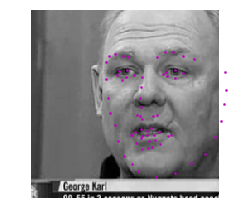

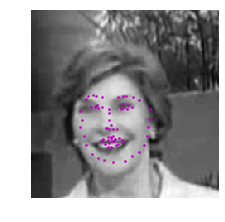

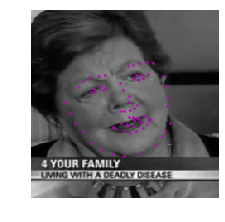



24


In [0]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

visualize_output(test_images, test_outputs, gt_pts)

gt_pts = gt_pts.float()

correct = 0

list_1 = gt_pts[1].cpu().numpy()
list_2 = test_outputs[1].detach().cpu().numpy()

for i in range(len(list_1)):
  pred = ( (list_1[i] - list_2[i]) <= 0.05 )
  if(pred.all()==True):
    correct += 1

print("\n")
print(correct)

In [0]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([40, 1, 227, 227])
torch.Size([40, 68, 2])
torch.Size([40, 68, 2])


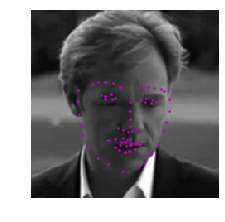

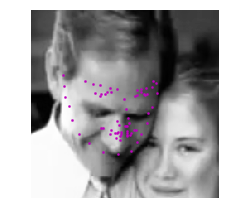

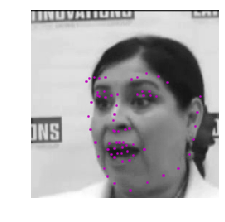

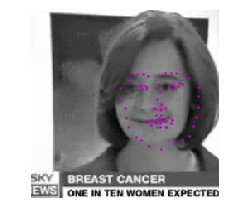

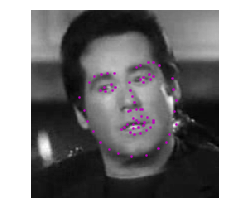

In [0]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)

*Save the trained model*

In [0]:

#!mkdir saved_models
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# NOTE : saved_models/keypoints_model_1.pt is for the modified LeNet I am finally using.
#        saved_models/keypoints_model_0.pt is a previous model that I had used. It is no longer needed.

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

*Test out some of the filters leanrt by the model for inferences*

Filter :
[[ 0.06392387  0.01484743  0.04541733  0.02138182]
 [ 0.00208434  0.07881477  0.04037008  0.04031486]
 [ 0.05415111  0.04951674 -0.04700981  0.04064902]
 [-0.07834717 -0.0635395  -0.06716431  0.01991775]]
Shape : (4, 4)


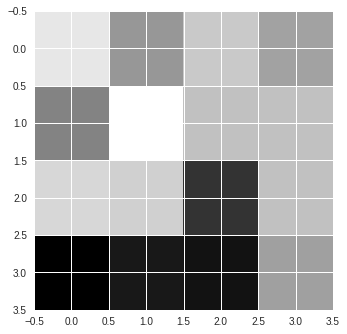

In [0]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.cpu().numpy()

filter_index = 11

print("Filter :")
print(w[filter_index][0])
print("Shape : " + str(w[filter_index][0].shape))

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')

[[-0.03314725 -0.0142282  -0.0140452  -0.06935981]
 [-0.11640476 -0.06662294 -0.0908767   0.01086166]
 [-0.09290741 -0.05854608 -0.05854217 -0.02125589]
 [-0.01365219  0.01763105  0.08442458  0.07955605]]
(4, 4)


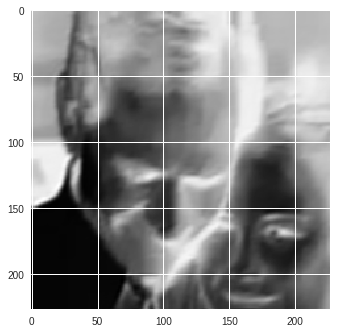

In [0]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
import cv2

weights1 = net.conv1.weight.data

w = weights1.cpu().numpy()

filter_index = 15

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
# plt.imshow(w[filter_index][0], cmap='gray')


idx_img = 1
img = np.squeeze(test_images[idx_img].data.cpu().numpy())

# plt.imshow(img, cmap="gray")

filtered_img = cv2.filter2D(img, -1, w[filter_index][0])
plt.imshow(filtered_img, cmap="gray")



---



---



*Now, the face Recognition pipeline starts*

---

*First : Load in face image of subject, Use haarcascades to detect face*

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [0]:
!mkdir images

In [0]:
!mv /AM-03.jpg images

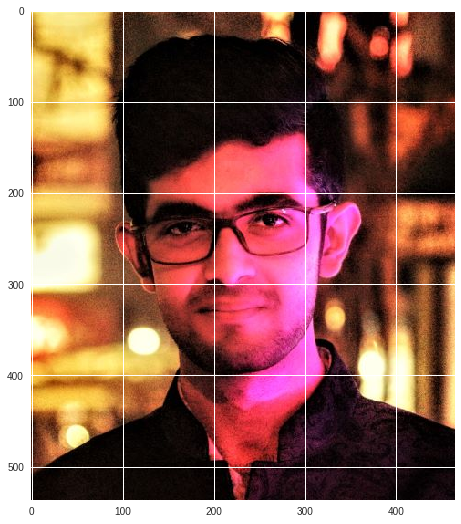

In [0]:
import cv2
# load in color image for face detection
image = cv2.imread('images/Profpic_Small.jpg.jpeg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

In [0]:
!mkdir detector_architectures

In [0]:
!mv /haarcascade_frontalface_default.xml detector_architectures

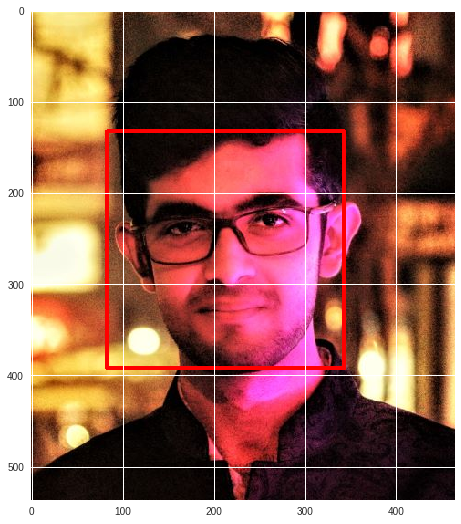

In [0]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

*Step 2 : Use the trained model developed to detect keypoints on this new face*

In [0]:
import torch
# from models import Net

net = Net()

## TODO: load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your* saved model
net.load_state_dict(torch.load('saved_models/keypoints_model_1.pt'))

## print out your net and prepare it for testing (uncomment the line below)
net.eval()

Net(
  (conv1): Conv2d(1, 96, kernel_size=(4, 4), stride=(4, 4))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=136, bias=True)
  (dropout2): Dropout(p=0.2)
  (dropout4): Dropout(p=0.4)
  (dropout6): Dropout(p=0.6)
  (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_

In [0]:
# NOTE: This function is same as the one provided by Udacity as template code in the previous notebook. 
#       Only the marker size has been changed after reading above example. 

def show_all_keypoints( predicted_key_pts):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.figure(figsize=(9,9))
    print(str(image.shape[0]) + str(image.shape[1]))
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=40, marker='.', c='m') 

537465


<Figure size 648x648 with 0 Axes>

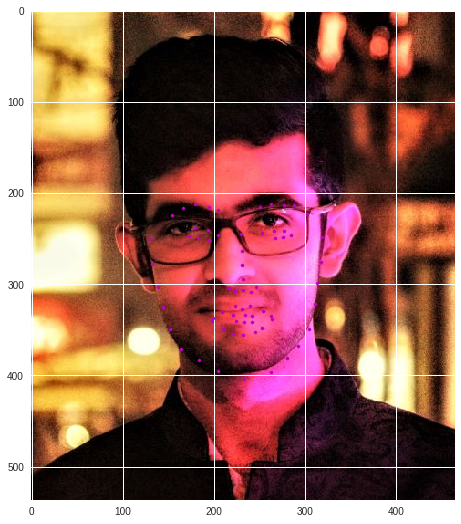

In [0]:
image_copy = np.copy(image)

# loop over the detected faces from your haar cascade
for (x,y,w,h) in faces:
    
    # Select the region of interest that is the face in the image 
    roi = image_copy[y:y+h, x:x+w] # the numeric values are needed for scaling the output keypoints correctly.
    width_roi = roi.shape[1] # needed later for scaling keypoints
    height_roi = roi.shape[0] # needed later for scaling keypoints
    roi_copy = np.copy(roi) # will be used as background to display final keypints.
    
    ## TODO: Convert the face region from RGB to grayscale
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

    ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi = roi/255.0
    
    ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    roi = cv2.resize(roi, (227, 227))  # resize the image to get a square 96*96 image.
    roi = np.reshape(roi,(227, 227, 1)) # reshape after rescaling to add the third color dimension.
    
    ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    roi = roi.transpose(2, 0, 1)
    
    ## TODO: Make facial keypoint predictions using your loaded, trained network 
    roi = torch.from_numpy(roi).type(torch.FloatTensor) # convert images to FloatTensors (common source of error)
    
    # Runtime error : expected stride to be a single integer value or a list of 1 values to match the convolution dimensions, 
    # but got stride=[1, 1]. This error will occur if the following line is omitted. Hence we need to apply unsqueeze operation.
    roi = roi.unsqueeze(0)
    
    # Pass the transformed input images to the network for detecting keypoints.
    keypoints = net(roi)
    keypoints = keypoints.view(68, 2)
    
    # Undo the transformations performed on the facial keypoints
    keypoints = keypoints.data.numpy()
    keypoints = keypoints*29.0 + 85
    
    ## TODO: Display each detected face and the corresponding keypoints        
    keypoints = keypoints * (width_roi / 96, height_roi / 90) # scale the keypoints to match the size of the output display.
    plt.figure(figsize=(9,9)) 
     
    # Using helper function for display as defined previously.  
    show_all_keypoints( keypoints)
    plt.show()

In [0]:
print(keypoints)

[[130.2062885  250.11262173]
 [132.7366209  277.5452084 ]
 [138.65463257 302.68263245]
 [143.88225396 324.76476203]
 [151.63048585 349.32554118]
 [163.92381112 371.30359565]
 [183.47501596 383.23807102]
 [204.17604129 395.16615465]
 [233.15536499 403.9670478 ]
 [263.16345533 395.71879747]
 [280.4458793  380.807095  ]
 [292.25049496 367.52387492]
 [305.00091553 348.95246209]
 [311.15628242 321.13520304]
 [313.25274467 298.66121589]
 [317.6865991  275.72931586]
 [318.98127715 248.54486084]
 [154.27857637 224.19419352]
 [166.01953983 215.9170261 ]
 [179.62755521 211.76411608]
 [194.75101153 214.58948432]
 [205.08682251 218.77933417]
 [250.46634515 215.25810411]
 [263.28259786 212.19189962]
 [277.19861507 212.8105757 ]
 [287.91090488 212.75629001]
 [302.53411134 223.08595445]
 [229.57978725 244.83939446]
 [230.47810872 262.92294142]
 [230.78718503 279.25389608]
 [232.36101945 293.78145515]
 [216.6365401  304.00790405]
 [223.30000877 307.85449558]
 [231.57983621 306.09698825]
 [240.72575092



---


*Step 3 : Align the faces using these keypoints*


---



**FACE ALIGNMENT **

---



*Import Header files*

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

*Define the hashing for keypoints *

In [0]:
from collections import OrderedDict
FACIAL_LANDMARKS_IDXS = OrderedDict([
	("mouth", (48, 68)),
	("right_eyebrow", (17, 22)),
	("left_eyebrow", (22, 27)),
	("right_eye", (36, 42)),
	("left_eye", (42, 48)),
	("nose", (27, 35)),
	("jaw", (0, 17))
])

![alt text](https://nbviewer.jupyter.org/github/iamshnoo/Udacity-CVND-P1---Facial-Keypoint-Detection/blob/master/images/landmarks_numbered.jpg)

---



*Face Aligner Class*</br>
***Inputs - Keypoints (detected above using AlexNet)***

In [0]:
class FaceAligner:
  
    def __init__(self,keypoints, desiredLeftEye=(0.35, 0.35),
        desiredFaceWidth=256, desiredFaceHeight=None):
        # store the facial landmark predictor, desired output left
        # eye position, and desired output face width + height
        self.keypoints=keypoints
        self.desiredLeftEye = desiredLeftEye
        self.desiredFaceWidth = desiredFaceWidth
        self.desiredFaceHeight = desiredFaceHeight
 
        # if the desired face height is None, set it to be the
        # desired face width (normal behavior)
        if self.desiredFaceHeight is None:
            self.desiredFaceHeight = self.desiredFaceWidth
          
    def align(self, keypoints):
        # convert the landmark (x, y)-coordinates to a NumPy array
        shape=keypoints

        # extract the left and right eye (x, y)-coordinates
        (lStart, lEnd) = FACIAL_LANDMARKS_IDXS["left_eye"]
        (rStart, rEnd) = FACIAL_LANDMARKS_IDXS["right_eye"]
        leftEyePts = shape[lStart:lEnd]
        rightEyePts = shape[rStart:rEnd]   
        
        # compute the center of mass for each eye
        leftEyeCenter = np.mean(leftEyePts,axis=0,dtype = np.dtype(np.int16))
        rightEyeCenter = np.mean(rightEyePts,axis=0,dtype = np.dtype(np.int16))
 
        # compute the angle between the eye centroids
        dY = rightEyeCenter[1] - leftEyeCenter[1]
        dX = rightEyeCenter[0] - leftEyeCenter[0]
        angle = np.degrees(np.arctan2(dY, dX)) - 180
        
        # compute the desired right eye x-coordinate based on the
        # desired x-coordinate of the left eye
        desiredRightEyeX = 1.0 - self.desiredLeftEye[0]
 
        # determine the scale of the new resulting image by taking
        # the ratio of the distance between eyes in the *current*
        # image to the ratio of distance between eyes in the
        # *desired* image
        dist = np.sqrt((dX ** 2) + (dY ** 2))
        desiredDist = (desiredRightEyeX - self.desiredLeftEye[0])
        desiredDist *= self.desiredFaceWidth
        scale = desiredDist / dist  

        # compute center (x, y)-coordinates (i.e., the median point)
        # between the two eyes in the input image
        eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) // 2,
            (leftEyeCenter[1] + rightEyeCenter[1]) // 2)
 
        # grab the rotation matrix for rotating and scaling the face
        M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)
 
        # update the translation component of the matrix
        tX = self.desiredFaceWidth * 0.5
        tY = self.desiredFaceHeight * self.desiredLeftEye[1]
        M[0, 2] += (tX - eyesCenter[0])
        M[1, 2] += (tY - eyesCenter[1])
        
        # apply the affine transformation
        (w, h) = (self.desiredFaceWidth, self.desiredFaceHeight)
        output = cv2.warpAffine(image, M, (w, h),
            flags=cv2.INTER_CUBIC)
 
        # return the aligned face
        return output


*Testing the Face aligner class*

In [0]:
import cv2
# load in color image for face detection
image = cv2.imread('images/Profpic_Small.jpg.jpeg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

In [0]:
fa = FaceAligner(keypoints, desiredFaceWidth=256)

# extract the ROI of the *original* face, then align the face
# using facial landmarks
# Using the faces returned by Haar Cascade step.
(x,y,w,h)=(2431, 725 ,1493 ,1493)

width = 256
height = 256
dim = (width,height)
faceOrig = cv2.resize(image[y:y + h, x:x + w], dim)
faceAligned = fa.align(keypoints)

plt.figure(figsize=(9,9))
plt.imshow(faceAligned)
plt.show()



**Following cells are only for experimental purposes. I don't have any results for this part (yet).**

---



**RESNET MODULE FOR CONVERTING IMAGES TO EMBEDDINGS**

---

*Transfer Learning using PyTorch*

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

*Neural Network Class*

In [0]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
"""
class CNN(nn.Module):
    def __init__(self, embed_size):
        super(CNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
"""
class Img2Vec():

    def __init__(self, cuda=True, layer_output_size=128):
      
        """ Img2Vec
        :param cuda: If set to True, will run forward pass on GPU
        :param model: String name of requested model
        :param layer: String or Int depending on model.  See more docs: https://github.com/christiansafka/img2vec.git
        :param layer_output_size: Int depicting the output size of the requested layer
        """
      
        self.device = torch.device("cuda")
        self.layer_output_size = layer_output_size
               
        self.model = models.resnet18(pretrained=True)
        self.extraction_layer = self.model._modules.get('fc')

        self.model = self.model.to(self.device)

        self.model.eval()

        self.scaler = transforms.Scale((227, 227))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()

    def get_vec(self, img, tensor=False):
        """ Get vector embedding from PIL image
        :param img: PIL Image
        :param tensor: If True, get_vec will return a FloatTensor instead of Numpy array
        :returns: Numpy ndarray
        """
        image = self.normalize(self.to_tensor(self.scaler(img))).unsqueeze(0).to(self.device)
        my_embedding = torch.zeros(1, self.layer_output_size, 1, 1)

        def copy_data(m, i, o):
            my_embedding.copy_(o.data)

        h = self.extraction_layer.register_forward_hook(copy_data)
        h_x = self.model(image)
        h.remove()

        if tensor:
            return my_embedding
        else:
            return my_embedding.numpy()[0, :, 0, 0]
              

*A simple metric to compare two embedded images*

In [0]:
from sklearn.metrics.pairwise import cosine_similarity
import os

pics = {}
for file in os.listdir(input_path):
    filename = os.fsdecode(file)
    img = Image.open(os.path.join(input_path, filename))
    vec = img2vec.get_vec(img)
    pics[filename] = vec

pic_name = ""
while pic_name != "exit":
    pic_name = str(input("Which filename would you like similarities for?\n"))

    try:
        sims = {}
        for key in list(pics.keys()):
            if key == pic_name:
                continue

            sims[key] = cosine_similarity(pics[pic_name].reshape((1, -1)), pics[key].reshape((1, -1)))[0][0]

        d_view = [(v, k) for k, v in sims.items()]
        d_view.sort(reverse=True)
        for v, k in d_view:
            print(v, k)

    except KeyError as e:
        print('Could not find filename %s' % e)

    except Exception as e:
        print(e)

In [0]:
import torch
import torch.nn as nn
import torchvision.models as models


class CNN(nn.Module):
    def __init__(self, embed_size):
        super(CNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features

In [0]:
![Alt](dkjcfbdacpfhahp)